In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set_theme(style="whitegrid")

paths1_df = pd.read_csv("AVMs4b/paths1_results.csv")
paths2_df = pd.read_csv("AVMs4b/paths2_results.csv")

paths1_df.head()

def extract_structure(df):
    """
    Returns:
        b_values: sorted list of block sizes
        var_map: dict {var_idx: [colnames]}
    """
    cols = [c for c in df.columns if c != "file_name"]
    var_map = {1: [], 2: [], 3: [], 4: []}
    b_values = set()

    for c in cols:
        # column format W{i}_{b}
        w, b = c.split("_")
        i = int(w[1])
        b = int(b)
        var_map[i].append(c)
        b_values.add(b)

    b_values = sorted(b_values)
    for k in var_map:
        var_map[k] = sorted(var_map[k], key=lambda x: int(x.split("_")[1]))

    return b_values, var_map


In [12]:
import numpy as np
import pandas as pd
import glob, os
from pathlib import Path
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# --- NEW: empirical F per system & observable, and the limit law  ∫_0^1 |B(u)| dQ(u) ---
# Here Q is the (empirical) quantile function of the observable distribution F
# compiled across ALL paths and ALL time points within a folder (approximated by subsampling).

def sample_observable_values(folder, col_idx, sample_per_file=2000, seed=0, file_glob="*.csv"):
    """
    Approximate the pooled marginal distribution F of one observable in a folder by
    random subsampling from each CSV file.

    Args:
        folder: e.g., "paths1" or "paths2"
        col_idx: 0..3 (th1, w1, th2, w2 in your convention)
        sample_per_file: how many points to sample from each file (None -> take all, may be huge)
        seed: RNG seed for reproducibility

    Returns:
        pooled_samples: 1D numpy array of sampled values across the folder
    """
    rng = np.random.default_rng(seed)
    files = sorted(glob.glob(os.path.join(folder, file_glob)))
    if not files:
        raise FileNotFoundError(f"No CSV files found in {folder}/")

    pooled = []
    for fp in files:
        arr = pd.read_csv(fp, usecols=[col_idx]).iloc[:, 0].to_numpy()
        arr = arr[np.isfinite(arr)]
        if arr.size == 0:
            continue
        if sample_per_file is None or sample_per_file >= arr.size:
            pooled.append(arr)
        else:
            idx = rng.choice(arr.size, size=sample_per_file, replace=False)
            pooled.append(arr[idx])

    if not pooled:
        raise ValueError(f"No finite values collected from {folder}/ for col_idx={col_idx}")

    return np.concatenate(pooled)

def empirical_quantile_grid(samples, n_u=2000, eps=1e-6):
    """
    Build an empirical quantile grid Q(u) on u-grid in (0,1).
    """
    u = np.linspace(eps, 1 - eps, n_u)
    q = np.quantile(samples, u, method="linear")
    return u, q

def simulate_bridge_stieltjes_integral(q_grid, n_samples=20000, batch_size=2000, seed=0):
    """
    Simulate A = ∫_0^1 |B(u)| dQ(u) using a left Riemann–Stieltjes sum:
        A ≈ Σ |B(u_i)| (Q(u_{i+1}) - Q(u_i))

    Args:
        q_grid: Q(u) values on a uniform u-grid (length n_u)
        n_samples: number of bridge paths
        batch_size: simulate in chunks to control memory
        seed: RNG seed

    Returns:
        areas: 1D array of length n_samples
    """
    rng = np.random.default_rng(seed)
    q = np.asarray(q_grid)
    n_u = q.size
    if n_u < 3:
        raise ValueError("q_grid must have length >= 3")

    dq = q[1:] - q[:-1]
    dt = 1.0 / (n_u - 1)

    out = np.empty(n_samples, dtype=float)
    done = 0

    while done < n_samples:
        m = min(batch_size, n_samples - done)

        # Brownian motion on uniform grid
        dW = np.sqrt(dt) * rng.standard_normal(size=(m, n_u - 1))
        W = np.concatenate([np.zeros((m, 1)), np.cumsum(dW, axis=1)], axis=1)

        # Brownian bridge: B(u) = W(u) - u W(1)
        u = np.linspace(0.0, 1.0, n_u)
        B = W - u[None, :] * W[:, [-1]]

        # Stieltjes left sum
        out[done:done+m] = (np.abs(B[:, :-1]) * dq[None, :]).sum(axis=1)
        done += m

    return out

def build_theory_samples_for_folder(folder, n_samples=20000, n_u=2000, sample_per_file=2000, seed=0, eps=1e-6):
    """
    For a given folder (system), compute the empirical quantile grids and simulate
    the limit distribution for each of the 4 observables.

    Returns:
        theory: dict {var_idx (1..4): {"u": u_grid, "q": q_grid, "areas": areas}}
    """
    theory = {}
    for var_idx in range(1, 5):
        col_idx = var_idx - 1
        pooled = sample_observable_values(folder, col_idx, sample_per_file=sample_per_file, seed=seed + 101*var_idx)
        u, q = empirical_quantile_grid(pooled, n_u=n_u, eps=eps)
        areas = simulate_bridge_stieltjes_integral(q, n_samples=n_samples, seed=seed + 999*var_idx)
        theory[var_idx] = {"u": u, "q": q, "areas": areas}
    return theory

def plot_overlay_grid_with_theory(df, theory, title, do_affine_scale=False):
    """
    Like plot_overlay_grid(), but adds theoretical KDE curves for each observable.

    If do_affine_scale=True:
        For each empirical curve (each b), plot an affinely transformed theory curve
        matching its mean and std (dashed, same color as empirical curve).

    If do_affine_scale=False:
        Plot the raw theoretical curve once (black dashed).
    """
    b_values, var_map = extract_structure(df)
    palette = sns.color_palette("tab10", len(b_values))

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.ravel()

    for var_idx in range(1, 5):
        ax = axes[var_idx - 1]
        cols = var_map[var_idx]

        th = theory[var_idx]["areas"]
        m_th = th.mean()
        s_th = th.std()

        # empirical AVMs by b
        for j, c in enumerate(cols):
            arr = df[c].dropna().values
            b = int(c.split("_")[1])

            color = palette[j]

            # empirical curve
            sns.kdeplot(
                arr,
                ax=ax,
                label=f"b={b}",
                color=color,
                linewidth=1.6
            )

            # corresponding theory curve
            if do_affine_scale and s_th > 0:
                m_emp = arr.mean()
                s_emp = arr.std()
                th_scaled = (th - m_th) / s_th * s_emp + m_emp

                sns.kdeplot(
                    th_scaled,
                    ax=ax,
                    color=color,
                    linestyle="--",
                    linewidth=1.8,
                    alpha=0.9
                )

        # if not affine scaling: plot raw theory once
        if not do_affine_scale:
            sns.kdeplot(
                th,
                ax=ax,
                label=r"$\int_0^1 |B(u)|\,dQ(u)$",
                color="black",
                linestyle="--",
                linewidth=2.2
            )

        ax.set_title(f"W{var_idx}")
        ax.set_xlabel("AVM")
        ax.set_ylabel("Density")
        ax.legend(fontsize=9)

    fig.suptitle(title, fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()


def ks_table_against_theory(df, theory, do_affine_scale=False, n=100_000):
    """
    KS test against the theory samples for each observable and b.

    Adds:
      - q = n // b
      - affine_mult = multiplicative scaling applied to theory samples

    Behavior:
      If do_affine_scale=True:
          th_use = (th - m_t)/s_t * s_a + m_a
          affine_mult = s_a / s_t

      If do_affine_scale=False:
          th_use = th / sqrt(q)
          affine_mult = 1 / sqrt(q)
    """
    b_values, var_map = extract_structure(df)
    rows = []

    for var_idx in range(1, 5):
        cols = var_map[var_idx]
        th = theory[var_idx]["areas"]
        m_t, s_t = th.mean(), th.std()

        for c in cols:
            arr = df[c].dropna().values
            if arr.size < 5:
                continue

            b = int(c.split("_")[1])
            q = n // b

            if do_affine_scale:
                m_a, s_a = arr.mean(), arr.std()
                if s_t == 0 or s_a == 0:
                    th_use = th * 0 + m_a
                    affine_mult = 0.0
                else:
                    affine_mult = s_a / s_t
                    th_use = (th - m_t) * affine_mult + m_a
            else:
                affine_mult = 1.0 / np.sqrt(q)
                th_use = th * affine_mult

            D, p = stats.ks_2samp(arr, th_use)

            rows.append({
                "W": var_idx,
                "b": b,
                "q": q,
                "affine_mult": affine_mult,
                "KS_D": D,
                "p_value": p
            })

    out = pd.DataFrame(rows).sort_values(["W", "b"]).reset_index(drop=True)
    return out


    W     b     q  affine_mult     KS_D   p_value
0   1    50  2000     0.010450  0.03630  0.158724
1   1   100  1000     0.013060  0.04710  0.028347
2   1   200   500     0.029968  0.02175  0.750086
3   1   500   200     0.045660  0.03625  0.159828
4   1  1000   100     0.087852  0.02385  0.641991
5   1  2000    50     0.136963  0.02150  0.762539
6   2    50  2000     0.009762  0.04110  0.078001
7   2   100  1000     0.014561  0.05220  0.010762
8   2   200   500     0.032757  0.04015  0.090410
9   2   500   200     0.052083  0.02770  0.450227
10  2  1000   100     0.092336  0.02045  0.812930
11  2  2000    50     0.145997  0.02630  0.517046
12  3    50  2000     0.016197  0.03420  0.210583
13  3   100  1000     0.018319  0.04360  0.052023
14  3   200   500     0.040378  0.01850  0.894268
15  3   500   200     0.073272  0.02115  0.779711
16  3  1000   100     0.096863  0.02080  0.796527
17  3  2000    50     0.132484  0.03665  0.151165
18  4    50  2000     0.049717  0.02345  0.662811


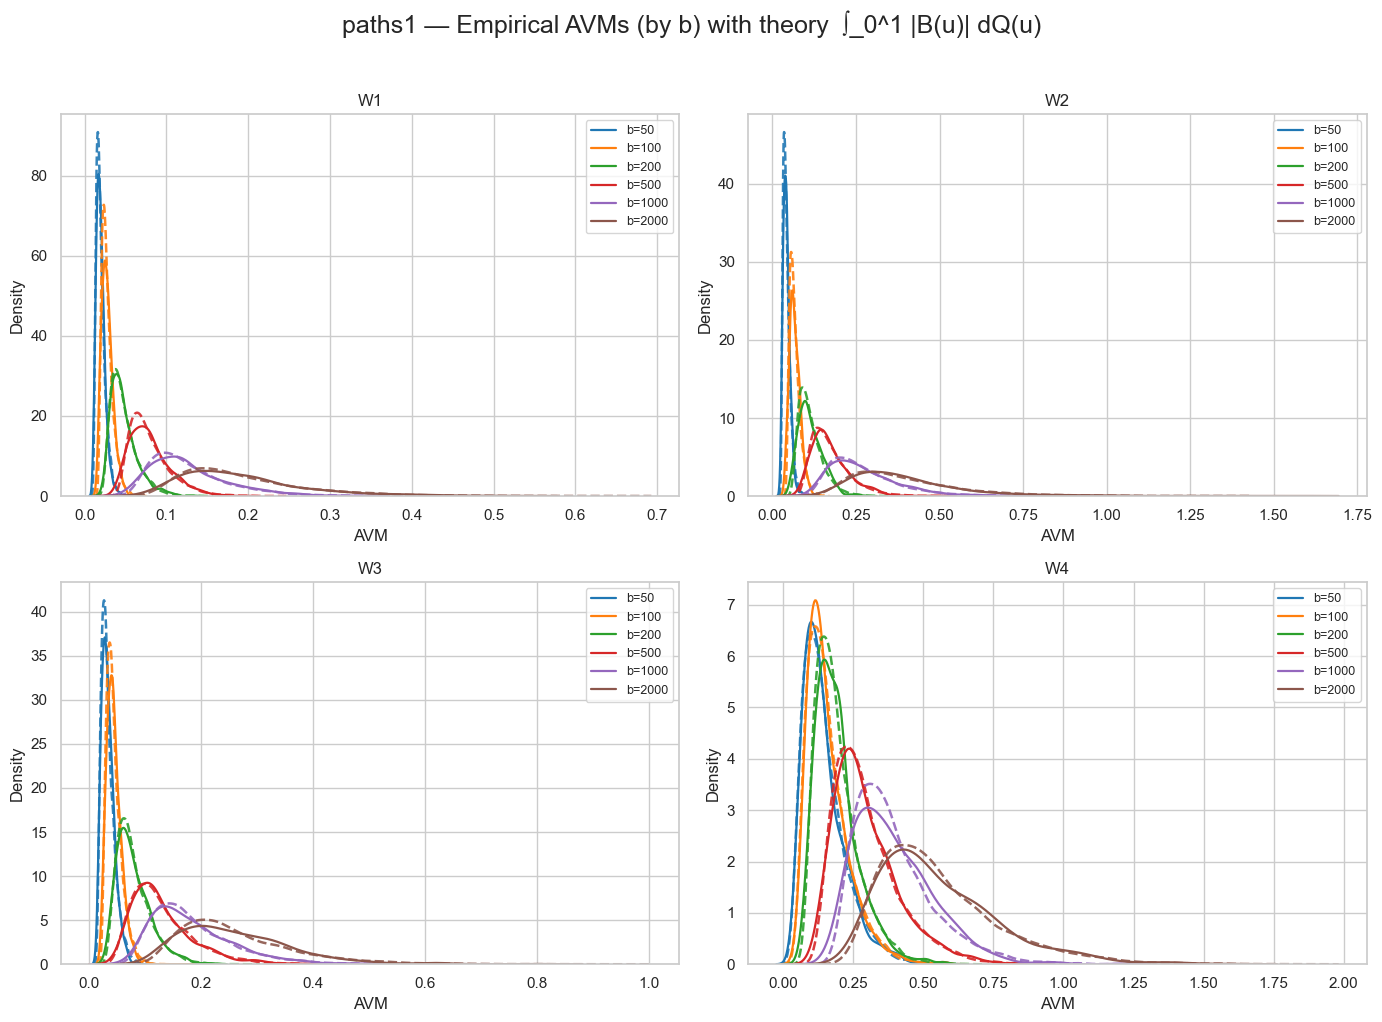

In [11]:
# Parameters
FOLDER = "paths1"          # folder containing the raw trajectories for system 1
N_SAMPLES = 20000          # number of Brownian-bridge paths for the theory curve
N_U = 2000                 # discretization of u in (0,1)
SAMPLE_PER_FILE = 2000     # subsample from each trajectory file to approximate pooled F
SEED = 42

# 1) Build theory samples (one per observable) using the empirical pooled F in this folder
theory_paths1 = build_theory_samples_for_folder(
    FOLDER,
    n_samples=N_SAMPLES,
    n_u=N_U,
    sample_per_file=SAMPLE_PER_FILE,
    seed=SEED
)

# 2) KS table (direct comparison; set do_affine_scale=True to match earlier behavior)
ks_df = ks_table_against_theory(paths1_df, theory_paths1, do_affine_scale=True)
print(ks_df)

# 3) Plots: empirical AVMs (by b) + theory curve  ∫ |B| dQ
plot_overlay_grid_with_theory(
    paths1_df,
    theory_paths1,
    title="paths1 — Empirical AVMs (by b) with theory  ∫_0^1 |B(u)| dQ(u)", 
    do_affine_scale=True
)


In [14]:
# Parameters
FOLDER = "paths1"          # folder containing the raw trajectories for system 1
N_SAMPLES = 20000          # number of Brownian-bridge paths for the theory curve
N_U = 2000                 # discretization of u in (0,1)
SAMPLE_PER_FILE = 2000     # subsample from each trajectory file to approximate pooled F
SEED = 42

# 1) Build theory samples (one per observable) using the empirical pooled F in this folder
theory_paths1 = build_theory_samples_for_folder(
    FOLDER,
    n_samples=N_SAMPLES,
    n_u=N_U,
    sample_per_file=SAMPLE_PER_FILE,
    seed=SEED
)

# 2) KS table (direct comparison; set do_affine_scale=True to match earlier behavior)
ks_df = ks_table_against_theory(paths1_df, theory_paths1, do_affine_scale=False)
print(ks_df)

    W     b     q  affine_mult     KS_D        p_value
0   1    50  2000     0.022361  0.46055  2.786230e-185
1   1   100  1000     0.031623  0.46250  6.101074e-187
2   1   200   500     0.044721  0.25625   1.317299e-55
3   1   500   200     0.070711  0.18820   5.368755e-30
4   1  1000   100     0.100000  0.06880   2.311029e-04
5   1  2000    50     0.141421  0.02320   6.758106e-01
6   2    50  2000     0.022361  0.45320  4.187701e-179
7   2   100  1000     0.031623  0.32630   9.400825e-91
8   2   200   500     0.044721  0.09170   2.040366e-07
9   2   500   200     0.070711  0.15250   8.510458e-20
10  2  1000   100     0.100000  0.04580   3.571284e-02
11  2  2000    50     0.141421  0.03215   2.728455e-01
12  3    50  2000     0.022361  0.19250   2.253316e-31
13  3   100  1000     0.031623  0.28370   2.724101e-68
14  3   200   500     0.044721  0.04625   3.299271e-02
15  3   500   200     0.070711  0.02935   3.778030e-01
16  3  1000   100     0.100000  0.01985   8.399332e-01
17  3  200

    W     b     KS_D        p_value
0   1    50  0.42730  2.619619e-158
1   1   100  0.40680  6.861711e-143
2   1   200  0.37800  9.922364e-123
3   1   500  0.28755   3.509788e-70
4   1  1000  0.21265   2.952257e-38
5   1  2000  0.11390   3.249349e-11
6   2    50  0.29320   5.270246e-73
7   2   100  0.28860   1.059413e-70
8   2   200  0.27645   8.312807e-65
9   2   500  0.25500   4.619296e-55
10  2  1000  0.23235   1.123329e-45
11  2  2000  0.18940   2.232601e-30
12  3    50  0.07220   9.238800e-05
13  3   100  0.03370   2.246671e-01
14  3   200  0.03925   1.036519e-01
15  3   500  0.02645   5.096825e-01
16  3  1000  0.02405   6.315870e-01
17  3  2000  0.01485   9.826831e-01
18  4    50  0.22850   3.586125e-44
19  4   100  0.22710   1.244637e-43
20  4   200  0.21600   1.806573e-39
21  4   500  0.20615   5.861692e-36
22  4  1000  0.18320   1.953225e-28
23  4  2000  0.15810   2.982925e-21


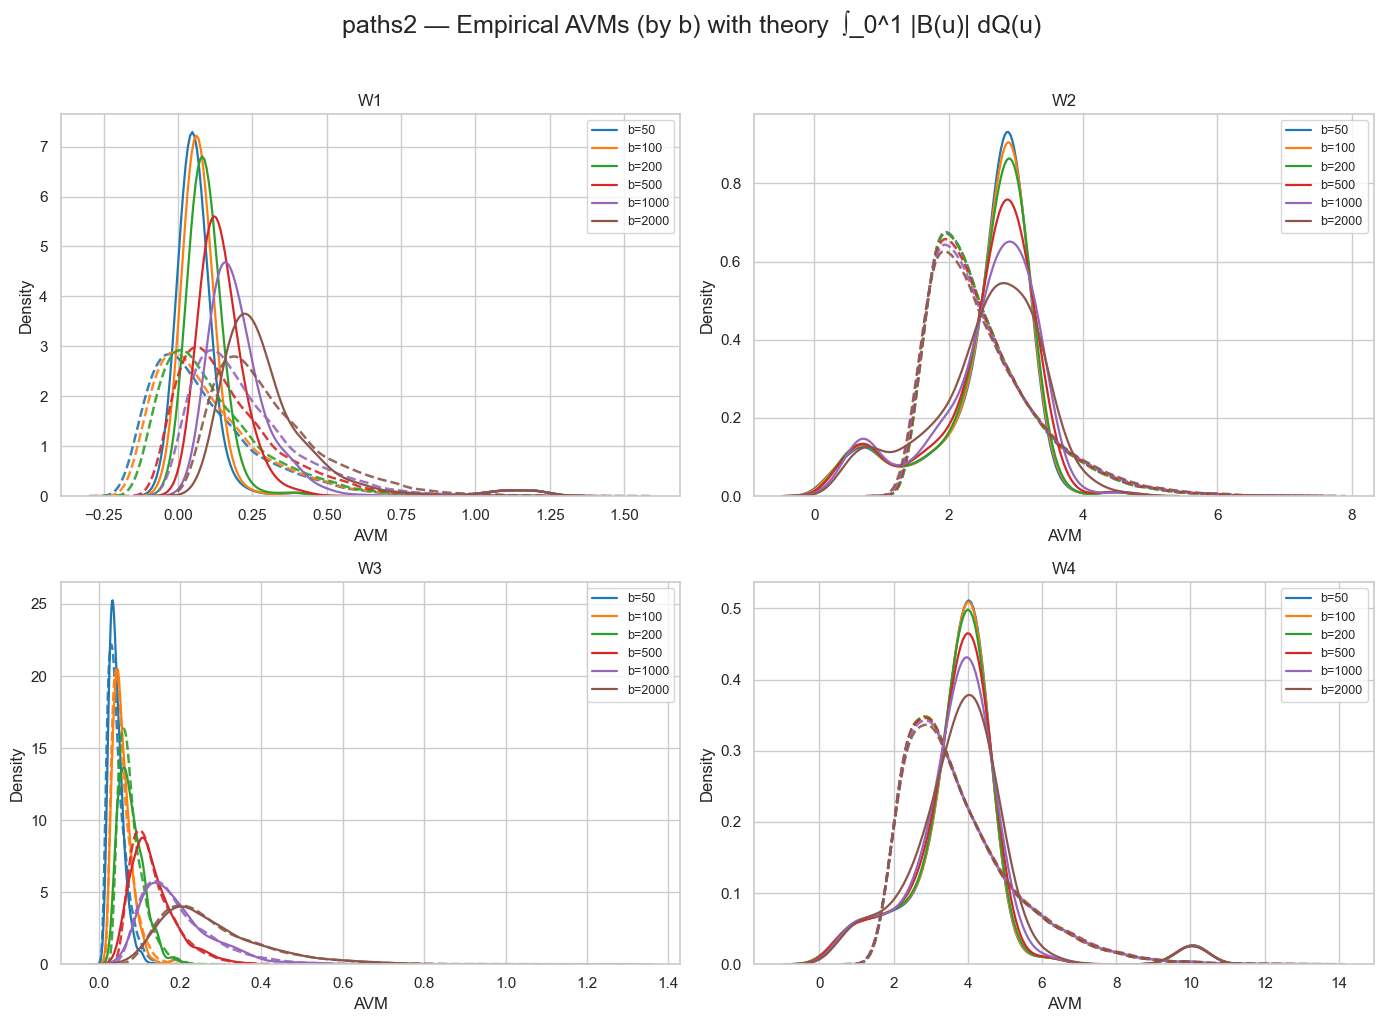

In [9]:
# Parameters
FOLDER = "paths2"          # folder containing the raw trajectories for system 2
N_SAMPLES = 20000          # number of Brownian-bridge paths for the theory curve
N_U = 2000                 # discretization of u in (0,1)
SAMPLE_PER_FILE = 2000     # subsample from each trajectory file to approximate pooled F
SEED = 42

# 1) Build theory samples (one per observable) using the empirical pooled F in this folder
theory_paths2 = build_theory_samples_for_folder(
    FOLDER,
    n_samples=N_SAMPLES,
    n_u=N_U,
    sample_per_file=SAMPLE_PER_FILE,
    seed=SEED
)

# 2) KS table (direct comparison; set do_affine_scale=True to match earlier behavior)
ks_df = ks_table_against_theory(paths2_df, theory_paths2, do_affine_scale=True)
print(ks_df)

# 3) Plots: empirical AVMs (by b) + theory curve  ∫ |B| dQ
plot_overlay_grid_with_theory(
    paths2_df,
    theory_paths2,
    title="paths2 — Empirical AVMs (by b) with theory  ∫_0^1 |B(u)| dQ(u)", 
    do_affine_scale=True
)
